In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

False

In [54]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100
device = torch.device("cpu")
print('using device:', device)

using device: cpu


In [55]:
def plotImage(image):
    return plt.imshow(image.T)

In [56]:
BASE = "lung_colon_image_set/"

In [57]:
class LungColonDS(torchvision.datasets.DatasetFolder):
    def find_classes(self, directory: str):
        classes = ["colon_image_sets/colon_aca","colon_image_sets/colon_n","lung_image_sets/lung_aca","lung_image_sets/lung_n","lung_image_sets/lung_scc"]
        return classes, {val:ind for ind, val in enumerate(classes)}

In [58]:
lung_colon_dataset = LungColonDS(BASE,torchvision.io.read_image, extensions = tuple([".jpeg"]))

In [59]:
import RotatedDataset
lung_colon_rotated_dataset = RotatedDataset.RotatedDataset(lung_colon_dataset)

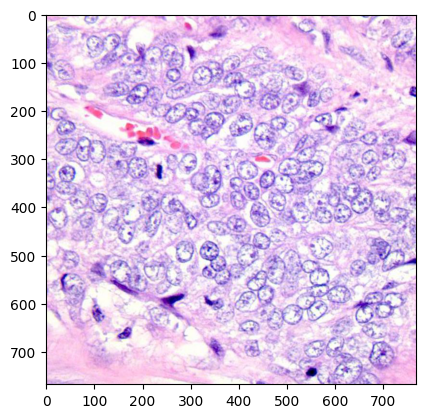

In [60]:
plotImage(lung_colon_rotated_dataset[0][0])

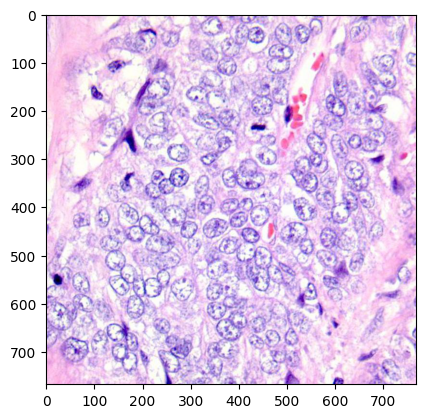

In [61]:
plotImage(lung_colon_rotated_dataset[1][0])

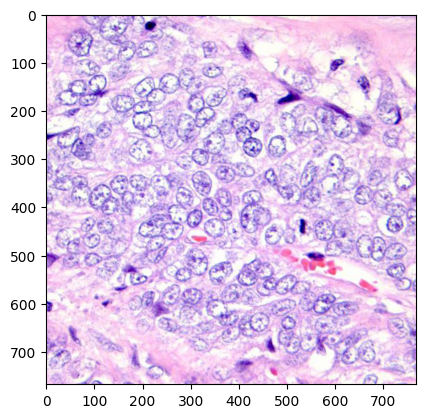

In [62]:
plotImage(lung_colon_rotated_dataset[2][0])

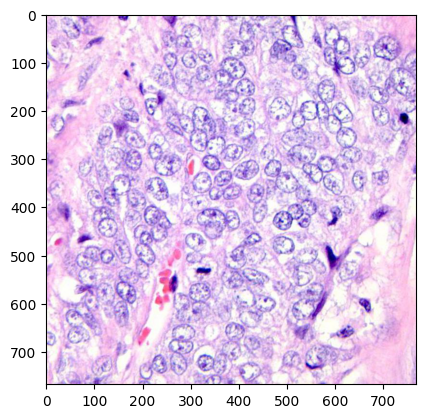

In [63]:
plotImage(lung_colon_rotated_dataset[3][0])

In [64]:
train_count = int(0.7*len(lung_colon_rotated_dataset))
valid_count = len(lung_colon_rotated_dataset) - train_count
train_dataset, valid_dataset = torch.utils.data.random_split(lung_colon_rotated_dataset, [train_count, valid_count])

# Making Dataloader
Dataloaders is how we will present the data to the trainer, so we need to create this object. In the future, these can be adjusted to handle any kind of new distribution we want to make

In [65]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

# Training Resnet With Rotated Images

In [66]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

In [67]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: mps


In [68]:
BASE = "lung_colon_image_set/"

In [69]:
class LungColonDS(torchvision.datasets.DatasetFolder):
    def find_classes(self, directory: str):
        classes = ["colon_image_sets/colon_aca","colon_image_sets/colon_n","lung_image_sets/lung_aca","lung_image_sets/lung_n","lung_image_sets/lung_scc"]
        return classes, {val:ind for ind, val in enumerate(classes)}

In [70]:
lung_colon_dataset = LungColonDS(BASE,torchvision.io.read_image, extensions = (".jpeg",))
import RotatedDataset
lung_colon_rotated_dataset = RotatedDataset.RotatedDataset(lung_colon_dataset)

In [71]:
lung_colon_dataset.classes

['colon_image_sets/colon_aca',
 'colon_image_sets/colon_n',
 'lung_image_sets/lung_aca',
 'lung_image_sets/lung_n',
 'lung_image_sets/lung_scc']

In [82]:
train_count = int(0.7*len(lung_colon_rotated_dataset))
valid_count = len(lung_colon_rotated_dataset) - train_count
train_dataset, valid_dataset = torch.utils.data.random_split(lung_colon_rotated_dataset, [train_count, valid_count])

In [83]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [84]:
import resnet
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [85]:
learning_rate = 2.5e-4
model = nn.Sequential(torchvision.transforms.Resize((32,32)),resnet.ResNet(batchNorm=True))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [86]:
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples if float(num_correct) != 0 else 0
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: The accuracy of the model
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_dataloader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(test_dataloader, model)
                print()
    return check_accuracy_part34(test_dataloader, model)

In [87]:
train_dataloader

In [88]:
print_every = 100
train_part34(model, optimizer, epochs=10)
print_every = 100

Epoch 0, Iteration 100, loss = 0.2893
Got 23959 / 30000 correct (79.86)

Epoch 0, Iteration 200, loss = 0.4438
